# plot data availability/number of data points

In [ ]:
#get_ipython().system(u'jupyter nbconvert --to=python MASTER_flux_seasonal_cycle_subareas.ipynb')

In [9]:
### modules
import os
import sys
sys.path.append('/home/ollie/jhauck/py_fesom/modules/')
import numpy as np
from scipy import stats
#import skill_metrics as sm #module installed on ollie
import seawater as sw
import matplotlib
#matplotlib.use('Agg') #changing backend
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from time import localtime, gmtime, strftime
from scipy import signal
from annualmean import annualmean
from netCDF4 import Dataset
#from mpl_toolkits.basemap import Basemap
from matplotlib import cm 
import numpy as np
from math import sin, cos, sqrt, atan2, radians, degrees
from numba import njit
from load_mesh_data_new import load_mesh

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('usepickle = ',usepickle)? (load_mesh_data_new.py, line 25)

In [6]:
simulation = 'A'

# specify years to average over
year1 = 1970 # years to average: e.g. 1982,2008,2013 each until 2018
year2 = 2018
eval_time = np.arange(year1,year2+1) 
gcb_time = np.arange(year1+1./24,year2+1,step=1./12)      
tsteps = (1+year2-year1)*12  
print(eval_time)
print(tsteps)

# SOCAT is on 1x1 grid already
# SOCCOM is ungridded: find closest node, assign month; (regridded vs native mesh)

# NOTE: 
# the landsea mask in the netcdf files is the one from RECCAP
#    i.e., it was used in the re-gridding of the model output to the regular 1x1 grid
#    (some of the SOCAT observations end up on land in the colocation procedure because of this mask, i.e., 
#     the total number of SOCAT points in model-based mask can be different from number of filled grid 
#     points in original SOCAT file)

# produced masks: 
# 1) SOCAT only    done
# 2) SOCCOM only   done
# 3) SOCAT+SOCCOM  done
# 4) ideal sampling grid?

savepath = './' #'/work/ollie/ncara/RECCAPv2/subsampling/plots_data_availability/' 
# check existence of paths
if not os.path.exists(savepath):
    print('Created '+savepath)
    os.makedirs(savepath)
print(savepath)    
#-----
# data files
#-----

# SOCAT
#socatfile = '/work/ollie/jhauck/gcp2018/2019_data/SOCATv2019_tracks_gridded_monthly.nc'
socatfile = '/work/ollie/ncara/observations/SOCATv2019/SOCATv2019_tracks_gridded_monthly.nc'
socatfile2 = '/work/ollie/ncara/observations/SOCATv2019/SOCATv2019_gridded_monthly_combined_with_SOCCOM.nc'

## FESOM-REcoM output 
#path = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019_post_processed_for_masks/'
#pco2file = path+'spco2_fesom_A_reg_1970_2019.nc'
#SSTfile  = path+'tos_fesom_A_reg_1970_2019.nc' # practical salinity!
#SSSfile  = path+'sos_fesom_A_reg_1970_2019.nc'
#Chlfile  = path+'chlos_fesom_A_reg_1970_2019.nc'
#MLDfile  = path+'mld_fesom_A_reg_1970_2019.nc'
#SSHfile  = path+'zos_fesom_A_reg_1970_2019.nc'

# SOCCOM
soccomfile = '/work/ollie/ncara/observations/SOCCOM_floats/soccom_float_pco2_2020.04.20_created_2020_05_14.nc'


[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983
 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018]
588
./


In [8]:
#-------
# land-sea mask
#-------

path_lsmask = '/work/ollie/ncara/RECCAPv2/reccap2ocean_regions.nc'
f3 = Dataset(path_lsmask)
mask_reccap = np.squeeze(f3.variables['reccap2_ocean_regions'][:,:])
#lon_ls_mask = np.squeeze(f3.variables['lon'][:])
#print lon_ls_mask

ls_mask_reccap = np.ones_like(mask_reccap) # 1=ocean, 0=land
ls_mask_reccap[mask_reccap==0]=0

#ind_land = ls_mask_reccap==0
print(ls_mask_reccap.shape)
print(ls_mask_reccap)

#------
# load mesh, get lat/lon
#------
meshpath   = '/work/ollie/jhauck/input/meshes/core_new_384/'
mesh       = load_mesh(meshpath,abg=[0,0,0])

mesh_lat = mesh.y2
mesh_lon = mesh.x2
# convert to radians, transform to one vector
mesh_lat_rad2 = [radians(x) for x in mesh_lat]
mesh_lon_rad2 = [radians(x) for x in mesh_lon]


(180, 360)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


NameError: name 'load_mesh' is not defined

In [4]:
#------
# FUNCTIONS
#------

def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        #data_transformed[0:180,:] = data[180:,:]
        #data_transformed[180:,:]  = data[0:180,:] 
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180]   
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        data_transformed[:,:,0:180] = data[:,:,180:]
        data_transformed[:,:,180:]  = data[:,:,0:180] 
    return data_transformed

In [5]:
#------
# load mesh, get lat/lon
#------

path = '/work/ollie/ncara/RECCAPv2/subsampling/model_data/'

f1 = Dataset(path+'FESOM_REcoM_output_from_native_grid_at_SOCAT_locations.nc')
f2 = Dataset(path+'FESOM_REcoM_output_from_native_grid_at_SOCCOM_locations.nc')
f3 = Dataset(path+'FESOM_REcoM_output_from_native_mesh_on_ideal_grid_6deg.nc')
f4 = Dataset(path+'FESOM_REcoM_output_from_native_grid_at_SOCAT_plus_SOCCOM_locations.nc')

pco2_socat  = f1.variables['pCO2_at_SOCAT'][:]
pco2_ideal  = f3.variables['pCO2_subsampled'][:]
pco2_socat_plus_soccom  = f4.variables['pCO2_at_SOCAT_plus_SOCCOM'][:]

lon_socat = f1.variables['lon'][:]
lat_socat = f1.variables['lat'][:]
num_time = pco2_socat.shape[0]

f1.close()
f2.close()
f3.close()
f4.close()


#----
# full field
#----
path = '/work/ollie/ncara/fesom/fesom-1.4-recom/v3/reccap_A_varCO2_varclim_1958_2019_post_processed_for_masks/'

f1 = Dataset(path+'spco2_fesom_A_reg_1970_2019.nc')
pco2_full  = f1.variables['spco2'][:-12,:,:] # load 1970-2018
pco2_full = transform_lon_coord(pco2_full)
f1.close()
#print pco2_full.shape

pco2_socat = np.reshape(pco2_socat,[num_time/12,12,180,360])
pco2_ideal = np.reshape(pco2_ideal,[num_time/12,12,180,360])
pco2_full = np.reshape(pco2_full,[num_time/12,12,180,360])

print 'pco2_socat_plus_soccom.shape',pco2_socat_plus_soccom.shape
print 'pco2_socat.shape',pco2_socat.shape
print 'pco2_ideal.shape',pco2_ideal.shape
print 'pco2_full.shape',pco2_full.shape

print ''
print 'Min/Max pCO2 in ideal grid',np.nanmin(pco2_ideal),np.nanmax(pco2_ideal)



/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less


pco2_socat_plus_soccom.shape (49, 12, 180, 360)
pco2_socat.shape (49, 12, 180, 360)
pco2_ideal.shape (49, 12, 180, 360)
pco2_full.shape (49, 12, 180, 360)

Min/Max pCO2 in ideal grid 178.108535767 1005.9486084


In [6]:
#------
# test plot
#------

dpicnt = 150
levels = np.arange(280.,445.,5.)
cticks = [280,320,360,400,440]
ms = 1

#----
# plot
#----

cmap1 = cm.inferno #RdYlBu_r #cm.Spectral_r
colorbar_string = '$\mu$atm'
parallels = [-60,-30,0,30,60]
meridians = [-120,-60,0,60,120]


print 'done'


done


In [41]:
#----
# plot time series of data availability
#----

display_plots = False

#----
# count number of points in the different masks
#----
pco2_socat[pco2_socat==-9999]=np.nan
pco2_ideal[pco2_ideal==-9999]=np.nan

which_region_list = ['global','north','south','tropics']
which_time_list = ['all_months','DJF','JJA','SON','MAM']

for rr in range(0,len(which_region_list)):
    for tt in range(0,len(which_time_list)):
        
        which_region = which_region_list[rr] # global, north, south, tropics
        which_time   = which_time_list[tt] # all_months, DJF, JJA

        print ''
        print 'Plot ',which_region,which_time
        
        if which_region in ['global']:
            ind_lat = np.where((lat_socat>=-90) & (lat_socat<90))[0]
        elif which_region in ['north']:
            ind_lat = np.where((lat_socat>=30) & (lat_socat<90))[0]
        elif which_region in ['south']:
            ind_lat = np.where((lat_socat>=-90) & (lat_socat<-30))[0]
        elif which_region in ['tropics']:
            ind_lat = np.where((lat_socat>=-30) & (lat_socat<30))[0]

        if which_time in ['all_months']:
            ind_months = range(0,12)
        elif which_time in ['DJF']:
            ind_months = [0,1,11]
        elif which_time in ['JJA']:
            ind_months = [5,6,7]
        elif which_time in ['SON']:
            ind_months = [8,9,10]
        elif which_time in ['MAM']:
            ind_months = [2,3,4]

        num_socat            = np.zeros([len(eval_time),12])
        num_socat_plus_socom = np.zeros([len(eval_time),12])
        num_ideal            = np.zeros([len(eval_time),12])
        for yy in range(0,len(eval_time)):
            for mm in ind_months:
                # socat
                #ind = np.where(~np.isnan(pco2_socat[yy,mm,:,:].ravel()))[0]
                ind = np.where(pco2_socat[yy,mm,ind_lat,:].ravel()>0)[0]
                #print ind.shape[0]
                num_socat[yy,mm] = ind.shape[0]
                del ind
                # socat+soccom
                ind = np.where(pco2_socat_plus_soccom[yy,mm,ind_lat,:].ravel()>0)[0]
                #print ind.shape[0]
                num_socat_plus_socom[yy,mm] = ind.shape[0]
                del ind
                # ideal
                ind = np.where(pco2_ideal[yy,mm,ind_lat,:].ravel()>0)[0]
                num_ideal[yy,mm] = ind.shape[0]
                del ind

        print 'Number in SOCAT:',np.sum(num_socat)
        print 'Number in SOCAT+SOCCOM:',np.sum(num_socat_plus_socom)
        print 'Number in ideal grid:',np.sum(num_ideal)

        #print 'Normalized by time (# per month):'
        #print 'Number in SOCAT:',np.sum(num_socat)/num_time
        #print 'Number in ideal grid:',np.sum(num_ideal)/num_time

        ## reshape to month x year
        #num_socat2 = np.reshape(num_socat,[num_time/12,12])
        #num_socom2 = np.reshape(num_socom,[num_time/12,12])
        #num_ideal2 = np.reshape(num_ideal,[num_time/12,12])
        #print num_socat2.shape
        #print num_socat.shape


        color1 = 'darkblue'
        color2 = 'cornflowerblue'
        color3 = 'lightsteelblue'
        color4 = 'orange'

        lw = 2
        fs = 12

        fig, axs = plt.subplots(1,1,figsize=(10,4), dpi=dpicnt,\
                                    gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
        plt.subplots_adjust(wspace=0.3)
        plt.subplots_adjust(hspace=0.5) 

        ax1 = plt.subplot2grid((1,1), (0, 0))#, colspan=2)
        #ax2 = plt.subplot2grid((4,1), (1, 0))

        ax=ax1

        ax.bar(eval_time,np.sum(num_socat_plus_socom,axis=1),color=color3,label='SOCCOM')
        ax.bar(eval_time,np.sum(num_socat,axis=1),color=color2,label='SOCAT')
        ax.plot(eval_time,np.sum(num_ideal,axis=1),color=color1,linewidth=lw,label='bgcARGO')
        #ax.bar(np.arange(0,len(eval_time)*12),num_socat,color=color1)

        ax.set_ylabel('Number of filled 1$^{\circ}$x1$^{\circ}$\ngrid cells in each year',fontsize=fs)

        handles, labels = ax.get_legend_handles_labels() 
        order = [2,1,0] ##specify order of items in legend
        if which_region in ['south']:
            ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                            bbox_to_anchor=(0.17, 0.92),ncol=1,fancybox=True, frameon=False,shadow=False,prop={'size': 10})
        else:
            ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
                            bbox_to_anchor=(0.17, 1),ncol=1,fancybox=True, frameon=False,shadow=False,prop={'size': 10})


        #ax.legend(loc='right',bbox_to_anchor=(1.0, 0.26), \
        #              ncol=1,markerfirst=False,fancybox=False, \
        #               frameon=False,shadow=False,prop={'size': 6}) 
        for label in ax.yaxis.get_majorticklabels():
                label.set_size(fs)
        for label in ax.xaxis.get_majorticklabels():
                label.set_size(fs)
        ax.annotate(which_region+', '+which_time, xy=(0.005,1.03),xycoords='axes fraction',\
                    fontsize=fs-1,fontweight='bold')
        
        # print some numbers into plot
        if which_region in ['south']:
            ax.annotate('avg. before 2000, 2000-2018, 2014-2018:',xy=(0.02,0.48),\
                    xycoords='axes fraction',fontsize=fs-2)
        else:
            ax.annotate('avg. before 2000, 2000-2018, 2014-2018:',xy=(0.02,0.4),\
                    xycoords='axes fraction',fontsize=fs-2)
        ax.annotate('SOCAT: '+\
                    str(np.int(np.round(np.mean(np.sum(num_socat[0:30],axis=1)))))+', '+\
                    str(np.int(np.round(np.mean(np.sum(num_socat[30:],axis=1)))))+', '+\
                    str(np.int(np.round(np.mean(np.sum(num_socat[30+14:],axis=1))))),\
                    xy=(0.02,0.32),xycoords='axes fraction',\
                    fontsize=fs-2)
        ax.annotate('bgcARGO: '+\
                    str(np.int(np.round(np.mean(np.sum(num_ideal,axis=1))))),\
                    xy=(0.02,0.24),xycoords='axes fraction',\
                    fontsize=fs-2)
        if which_region in ['south']:
            ax.annotate('SOCAT+SOCCOM: '+\
                    str(np.int(np.round(np.mean(np.sum(num_socat_plus_socom[0:30],axis=1)))))+', '+\
                    str(np.int(np.round(np.mean(np.sum(num_socat_plus_socom[30:],axis=1)))))+', '+\
                    str(np.int(np.round(np.mean(np.sum(num_socat_plus_socom[30+14:],axis=1))))),\
                    xy=(0.02,0.40),xycoords='axes fraction',\
                    fontsize=fs-2)

        plt.savefig(savepath+'Data_availability_timeSeries_'+which_region+'_'+which_time+\
                    '_number_filled_grid_points.png',\
                        dpi = dpicnt, bbox_inches='tight')

        #display_plots = True
        if display_plots:
            plt.show()
        else: 
            plt.close(fig)





Plot  global all_months
Number in SOCAT: 298602.0
Number in SOCAT+SOCCOM: 301853.0
Number in ideal grid: 589176.0

Plot  global DJF
Number in SOCAT: 76644.0
Number in SOCAT+SOCCOM: 77364.0
Number in ideal grid: 147294.0

Plot  global JJA
Number in SOCAT: 74837.0
Number in SOCAT+SOCCOM: 75672.0
Number in ideal grid: 147294.0

Plot  global SON
Number in SOCAT: 74967.0
Number in SOCAT+SOCCOM: 75777.0
Number in ideal grid: 147294.0

Plot  global MAM
Number in SOCAT: 72154.0
Number in SOCAT+SOCCOM: 73040.0
Number in ideal grid: 147294.0

Plot  north all_months
Number in SOCAT: 130946.0
Number in SOCAT+SOCCOM: 130946.0
Number in ideal grid: 104664.0

Plot  north DJF
Number in SOCAT: 22900.0
Number in SOCAT+SOCCOM: 22900.0
Number in ideal grid: 26166.0

Plot  north JJA
Number in SOCAT: 40464.0
Number in SOCAT+SOCCOM: 40464.0
Number in ideal grid: 26166.0

Plot  north SON
Number in SOCAT: 35408.0
Number in SOCAT+SOCCOM: 35408.0
Number in ideal grid: 26166.0

Plot  north MAM
Number in SOCAT: 3

In [ ]:
#-----
# rel. frequency vs pCO2; pre 2000
#-----
# alternativ oder zusätzlich kann man die Anzahl der Datenpunkte als Barplot (Gauss-Verteilung) 
# gegen pCO2 auf der x-Achse plotten. Dann sieht man vielleicht auch was 

ind_start,ind_end = 0,30 # pre 2000
#ind_start,ind_end = 30,-1 # after 2000
#ind_start,ind_end = 0,-1 # 0,-1 -> all data


which_region = 'global' # global, north, south, tropics

if which_region in ['global']:
    ind_lat = np.where((lat_socat>=-90) & (lat_socat<90))[0]
elif which_region in ['north']:
    ind_lat = np.where((lat_socat>=30) & (lat_socat<90))[0]
elif which_region in ['south']:
    ind_lat = np.where((lat_socat>=-90) & (lat_socat<-30))[0]
elif which_region in ['tropics']:
    ind_lat = np.where((lat_socat>=-30) & (lat_socat<30))[0]
    
print ind_lat.shape

# socat
a1 = np.copy(pco2_socat[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a1>0)[0]
a1=a1[ind]
print a1.shape
print 'Min/Max pCO2 in SOCAT:',np.min(a1),np.max(a1)

n = 5 # width of bins
bins = np.arange(np.floor(np.min(a1)),np.ceil(np.max(a1))+n,n) #280.,450.,10.)
print 'Min/Max bin:',np.min(bins),np.max(bins)

dig1 = np.digitize(a1,bins,right=True)

# ideal grid
a2 = np.copy(pco2_ideal[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a2>0)[0]
a2=a2[ind]
dig2 = np.digitize(a2,bins,right=True)

# SOCAT+SOCCOM
a3 = np.copy(pco2_socat_plus_soccom[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a3>0)[0]
a3=a3[ind]
dig3 = np.digitize(a3,bins,right=True)

# FESOM-REcoM
a4 = np.copy(pco2_full[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a4>0)[0]
a4=a4[ind]
dig4 = np.digitize(a4,bins,right=True)


num_socat_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig1==ii)[0]
    num_socat_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_socat_plus_soccom_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig3==ii)[0]
    num_socat_plus_soccom_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_ideal_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig2==ii)[0]
    num_ideal_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_full_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig4==ii)[0]
    num_full_pco2_bins[ii] = ind.shape[0]
    del ind

# check if all obs have been captured in bins
print np.sum(num_socat)
print np.sum(num_socat_pco2_bins)


fig, axs = plt.subplots(1,1,figsize=(6,4), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2) 

ax1 = plt.subplot2grid((1,1), (0, 0))#, colspan=2)
#ax2 = plt.subplot2grid((1,2), (0, 1))

ax=ax1
#ax.bar(bins,num_socat_pco2_bins/np.sum(num_socat_pco2_bins),color=color1,width=5)
ax.plot(bins,num_socat_pco2_bins/np.sum(num_socat_pco2_bins),\
        color=color2,linewidth=lw,label='SOCAT')
if eval_time[ind_start]>1999: # with SOCCOM
    ax.plot(bins,num_socat_plus_soccom_pco2_bins/np.sum(num_socat_plus_soccom_pco2_bins),\
        color=color3,linewidth=lw,linestyle='--',label='SOCAT+SOCCOM')
ax.plot(bins,num_ideal_pco2_bins/np.sum(num_ideal_pco2_bins),\
        color=color1,linewidth=lw,label='bgcARGO')
ax.plot(bins,num_full_pco2_bins/np.sum(num_full_pco2_bins),\
        color=color4,linewidth=lw,label='FESOM-REcoM')
ax.set_xlim((180,600))

#ax=ax2
#ax.bar(bins,num_ideal_pco2_bins/np.sum(num_ideal_pco2_bins),color=color2,width=5)
#ax.set_xlim((180,600))

#ax.plot(eval_time,np.sum(num_ideal2,axis=1),color=color2,linewidth=lw)
#ax.bar(np.arange(0,len(eval_time)*12),num_socat,color=color1)

ax.set_ylabel('relative frequency',fontsize=fs)
ax.set_xlabel('pCO$_{2}$ in $\mu$atm',fontsize=fs)

ax.legend(loc='right',bbox_to_anchor=(0.99,0.84), \
                   ncol=1,fancybox=False, markerfirst=False,shadow=False,frameon=False, prop={'size': 10})

if (ind_start==30) & (ind_end==-1):
    ax.annotate('2000 and later', xy=(0.03,0.92),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
elif (ind_start==0) & (ind_end==30):
    ax.annotate('pre 2000', xy=(0.03,0.92),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
ax.annotate(which_region, xy=(0.03,0.83),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')

ax.set_ylim((0,0.1))
    
plt.savefig(savepath+'Data_availability_'+which_region+'_pre_2000_relFreq_vs_pCO2.png',\
                dpi = dpicnt, bbox_inches='tight')

plt.show()


#------
# is there any difference between decades?
# any difference between season?
#------


(180,)
(232709,)
Min/Max pCO2 in SOCAT: 170.616104126 1056.66943359
Min/Max bin: 170.0 1060.0


/global/AWIsoft/intel/2018/intelpython2/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


27024.0
232709.0


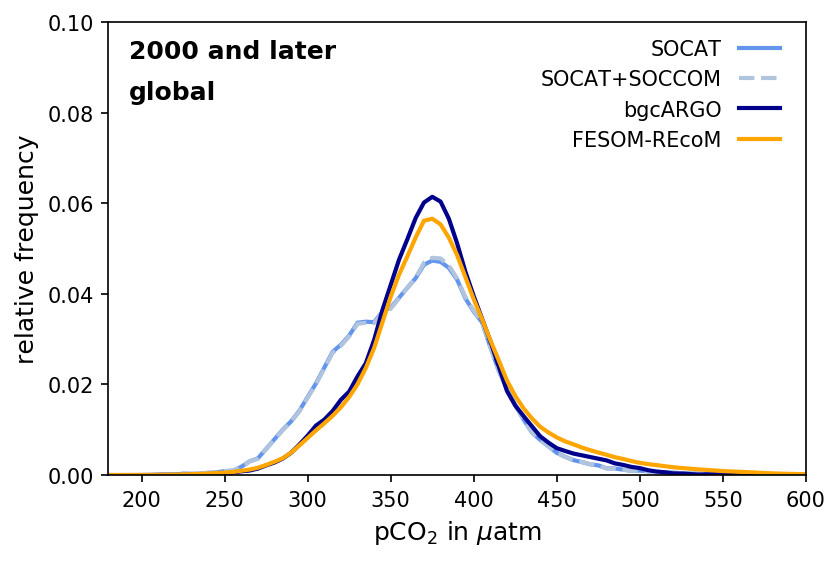

In [42]:
#-----
# rel. frequency vs pCO2; after 2000
#-----

#ind_start,ind_end = 0,30 # pre 2000
ind_start,ind_end = 30,-1 # after 2000
#ind_start,ind_end = 0,-1 # 0,-1 -> all data
    
which_region = 'global' # global, north, south, tropics

if which_region in ['global']:
    ind_lat = np.where((lat_socat>=-90) & (lat_socat<90))[0]
elif which_region in ['north']:
    ind_lat = np.where((lat_socat>=30) & (lat_socat<90))[0]
elif which_region in ['south']:
    ind_lat = np.where((lat_socat>=-90) & (lat_socat<-30))[0]
elif which_region in ['tropics']:
    ind_lat = np.where((lat_socat>=-30) & (lat_socat<30))[0]
    
print ind_lat.shape

# socat
a1 = np.copy(pco2_socat[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a1>0)[0]
a1=a1[ind]
print a1.shape
print 'Min/Max pCO2 in SOCAT:',np.min(a1),np.max(a1)

n = 5 # width of bins
bins = np.arange(np.floor(np.min(a1)),np.ceil(np.max(a1))+n,n) #280.,450.,10.)
print 'Min/Max bin:',np.min(bins),np.max(bins)

dig1 = np.digitize(a1,bins,right=True)

# ideal grid
a2 = np.copy(pco2_ideal[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a2>0)[0]
a2=a2[ind]
dig2 = np.digitize(a2,bins,right=True)

# SOCAT+SOCCOM
a3 = np.copy(pco2_socat_plus_soccom[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a3>0)[0]
a3=a3[ind]
dig3 = np.digitize(a3,bins,right=True)

# FESOM-REcoM
a4 = np.copy(pco2_full[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a4>0)[0]
a4=a4[ind]
dig4 = np.digitize(a4,bins,right=True)

num_socat_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig1==ii)[0]
    num_socat_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_socat_plus_soccom_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig3==ii)[0]
    num_socat_plus_soccom_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_ideal_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig2==ii)[0]
    num_ideal_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_full_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig4==ii)[0]
    num_full_pco2_bins[ii] = ind.shape[0]
    del ind

# check if all obs have been captured in bins
print np.sum(num_socat)
print np.sum(num_socat_pco2_bins)


fig, axs = plt.subplots(1,1,figsize=(6,4), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2) 

ax1 = plt.subplot2grid((1,1), (0, 0))#, colspan=2)
#ax2 = plt.subplot2grid((1,2), (0, 1))

ax=ax1
#ax.bar(bins,num_socat_pco2_bins/np.sum(num_socat_pco2_bins),color=color1,width=5)
ax.plot(bins,num_socat_pco2_bins/np.sum(num_socat_pco2_bins),\
        color=color2,linewidth=lw,label='SOCAT')
if eval_time[ind_start]>1999: # with SOCCOM
    ax.plot(bins,num_socat_plus_soccom_pco2_bins/np.sum(num_socat_plus_soccom_pco2_bins),\
        color=color3,linewidth=lw,linestyle='--',label='SOCAT+SOCCOM')
ax.plot(bins,num_ideal_pco2_bins/np.sum(num_ideal_pco2_bins),\
        color=color1,linewidth=lw,label='bgcARGO')
ax.plot(bins,num_full_pco2_bins/np.sum(num_full_pco2_bins),\
        color=color4,linewidth=lw,label='FESOM-REcoM')
ax.set_xlim((180,600))

#ax=ax2
#ax.bar(bins,num_ideal_pco2_bins/np.sum(num_ideal_pco2_bins),color=color2,width=5)
#ax.set_xlim((180,600))

#ax.plot(eval_time,np.sum(num_ideal2,axis=1),color=color2,linewidth=lw)
#ax.bar(np.arange(0,len(eval_time)*12),num_socat,color=color1)

ax.set_ylabel('relative frequency',fontsize=fs)
ax.set_xlabel('pCO$_{2}$ in $\mu$atm',fontsize=fs)

ax.legend(loc='right',bbox_to_anchor=(0.99,0.84), \
                   ncol=1,fancybox=False, markerfirst=False,shadow=False,frameon=False, prop={'size': 10})

if (ind_start==30) & (ind_end==-1):
    ax.annotate('2000 and later', xy=(0.03,0.92),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
elif (ind_start==0) & (ind_end==30):
    ax.annotate('pre 2000', xy=(0.03,0.92),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
ax.annotate(which_region, xy=(0.03,0.83),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
ax.set_ylim((0,0.1))
    
plt.savefig(savepath+'Data_availability_'+which_region+'_after_2000_relFreq_vs_pCO2.png',\
                dpi = dpicnt, bbox_inches='tight')

plt.show()


#------
# is there any difference between decades?
# any difference between season?
#------



(60,)
(12382,)
Min/Max pCO2 in SOCAT: 190.59185791 1056.66943359
Min/Max bin: 190.0 1060.0
27024.0
12382.0


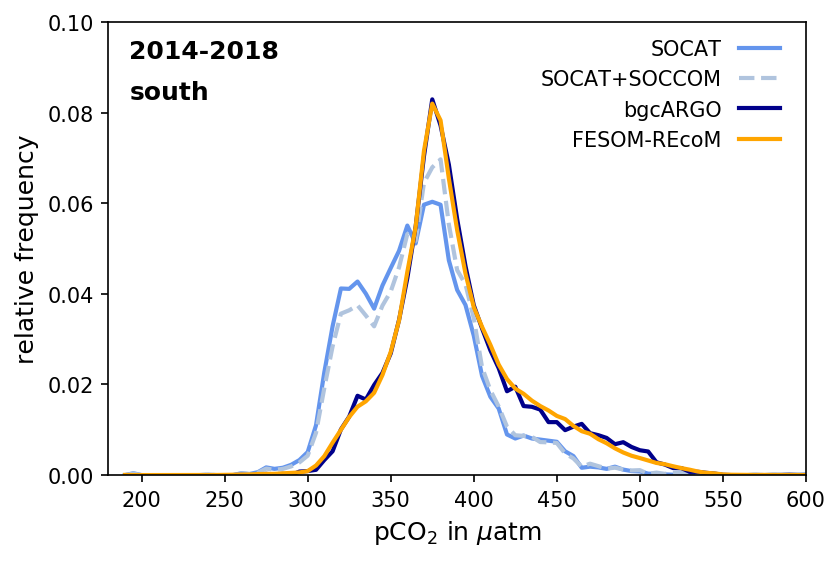

In [46]:
#-----
# rel. frequency vs pCO2; 2014-2018
#-----

#ind_start,ind_end = 0,30 # pre 2000
ind_start,ind_end = 30+14,-1 # 2014-2018
#ind_start,ind_end = 0,-1 # 0,-1 -> all data
    
which_region = 'south' # global, north, south, tropics

if which_region in ['global']:
    ind_lat = np.where((lat_socat>=-90) & (lat_socat<90))[0]
elif which_region in ['north']:
    ind_lat = np.where((lat_socat>=30) & (lat_socat<90))[0]
elif which_region in ['south']:
    ind_lat = np.where((lat_socat>=-90) & (lat_socat<-30))[0]
elif which_region in ['tropics']:
    ind_lat = np.where((lat_socat>=-30) & (lat_socat<30))[0]
    
print ind_lat.shape

# socat
a1 = np.copy(pco2_socat[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a1>0)[0]
a1=a1[ind]
print a1.shape
print 'Min/Max pCO2 in SOCAT:',np.min(a1),np.max(a1)

n = 5 # width of bins
bins = np.arange(np.floor(np.min(a1)),np.ceil(np.max(a1))+n,n) #280.,450.,10.)
print 'Min/Max bin:',np.min(bins),np.max(bins)

dig1 = np.digitize(a1,bins,right=True)

# ideal grid
a2 = np.copy(pco2_ideal[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a2>0)[0]
a2=a2[ind]
dig2 = np.digitize(a2,bins,right=True)

# SOCAT+SOCCOM
a3 = np.copy(pco2_socat_plus_soccom[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a3>0)[0]
a3=a3[ind]
dig3 = np.digitize(a3,bins,right=True)

# FESOM-REcoM
a4 = np.copy(pco2_full[ind_start:ind_end,:,ind_lat,:]).ravel()
ind = np.where(a4>0)[0]
a4=a4[ind]
dig4 = np.digitize(a4,bins,right=True)

num_socat_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig1==ii)[0]
    num_socat_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_socat_plus_soccom_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig3==ii)[0]
    num_socat_plus_soccom_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_ideal_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig2==ii)[0]
    num_ideal_pco2_bins[ii] = ind.shape[0]
    del ind
    
num_full_pco2_bins = np.zeros([len(bins)])
for ii in range(0,len(bins)):
    ind = np.where(dig4==ii)[0]
    num_full_pco2_bins[ii] = ind.shape[0]
    del ind

# check if all obs have been captured in bins
print np.sum(num_socat)
print np.sum(num_socat_pco2_bins)


fig, axs = plt.subplots(1,1,figsize=(6,4), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1],'height_ratios': [1]})
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2) 

ax1 = plt.subplot2grid((1,1), (0, 0))#, colspan=2)
#ax2 = plt.subplot2grid((1,2), (0, 1))

ax=ax1
#ax.bar(bins,num_socat_pco2_bins/np.sum(num_socat_pco2_bins),color=color1,width=5)
ax.plot(bins,num_socat_pco2_bins/np.sum(num_socat_pco2_bins),\
        color=color2,linewidth=lw,label='SOCAT')
if eval_time[ind_start]>1999: # with SOCCOM
    ax.plot(bins,num_socat_plus_soccom_pco2_bins/np.sum(num_socat_plus_soccom_pco2_bins),\
        color=color3,linewidth=lw,linestyle='--',label='SOCAT+SOCCOM')
ax.plot(bins,num_ideal_pco2_bins/np.sum(num_ideal_pco2_bins),\
        color=color1,linewidth=lw,label='bgcARGO')
ax.plot(bins,num_full_pco2_bins/np.sum(num_full_pco2_bins),\
        color=color4,linewidth=lw,label='FESOM-REcoM')
ax.set_xlim((180,600))

#ax=ax2
#ax.bar(bins,num_ideal_pco2_bins/np.sum(num_ideal_pco2_bins),color=color2,width=5)
#ax.set_xlim((180,600))

#ax.plot(eval_time,np.sum(num_ideal2,axis=1),color=color2,linewidth=lw)
#ax.bar(np.arange(0,len(eval_time)*12),num_socat,color=color1)

ax.set_ylabel('relative frequency',fontsize=fs)
ax.set_xlabel('pCO$_{2}$ in $\mu$atm',fontsize=fs)

ax.legend(loc='right',bbox_to_anchor=(0.99,0.84), \
                   ncol=1,fancybox=False, markerfirst=False,shadow=False,frameon=False, prop={'size': 10})

if (ind_start==30) & (ind_end==-1):
    ax.annotate('2000 and later', xy=(0.03,0.92),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
elif (ind_start==0) & (ind_end==30):
    ax.annotate('pre 2000', xy=(0.03,0.92),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
elif (ind_start==30+14) & (ind_end==-1):
    ax.annotate('2014-2018', xy=(0.03,0.92),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
ax.annotate(which_region, xy=(0.03,0.83),xycoords='axes fraction',\
            fontsize=fs,fontweight='bold')
ax.set_ylim((0,0.1))
    
plt.savefig(savepath+'Data_availability_'+which_region+'_2014_2018_relFreq_vs_pCO2.png',\
                dpi = dpicnt, bbox_inches='tight')

plt.show()


#------
# is there any difference between decades?
# any difference between season?
#------


